In [15]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE
 
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)
from time import process_time 
import scipy
from scipy.optimize import minimize

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
def proxy(a,y_train,m0,output):
    m_t = (m0-y_train.mean(axis=0))/y_train.std(axis=0)
    y_t = (y_train-y_train.mean(axis=0))/y_train.std(axis=0)
    a=torch.tensor(a)
    res = ((a*m_t-y_t)**2).mean(axis=0).detach().numpy()
    return res[output]

In [18]:
def m0_mat(y_test,emulators,x_test,output):

    m0=torch.zeros((y_test.shape[0],len(emulators)))
    for i in range(len(emulators)):
        m0[:,i]=(emulators[i].predict(x_test)[:,output]-y_train.mean(axis=0)[output])/y_train.std(axis=0)[output]


    return m0

In [19]:
model = Pipeline(steps=[
    #('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(degree=1, include_bias=False,interaction_only=False)),
    ('lasso', LassoCV(n_alphas=1000,max_iter=10000))
])


In [20]:
meshes=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','16','17','18','19']

Ys=[]
Xs=[]
emulators=[]
for i in range(len(meshes)):
    val=meshes[i]
    
    inputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
    Xs.append(torch.tensor(inputData))
    Ys.append(torch.tensor(outputData))
    emulator = GPE.ensemble(Xs[i],Ys[i],mean_func="linear",training_iter=500)
    emulators.append(emulator)

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


In [21]:
emn = [1,3,5,7,9,11,13,15,17]
reps=1
n=20
R2_all=torch.zeros(len(emn),2,reps)
R2_lasso=torch.zeros(len(emn),2,reps)
R2_lasso_i=torch.zeros(len(emn),2,reps)


for k in range(len(emulators)):
    emulators2=emulators.copy()
    emulators2.pop(k)
    print(len(emulators2))
    X_train, X_test, y_train, y_test = train_test_split(
                Xs[k].float(),
                Ys[k].float(),
                test_size=0.1,
                random_state=seed
            )
    for m in range(len(emn)):
        a =np.random.choice(len(emulators2),emn[m],replace=False)
        emulators3 = np.array(emulators2)[a].tolist()
        print(emulators3)
        for i in range(reps):
            
            b=np.random.choice(range(X_train.shape[0]),n,replace=False)

            model_dc_all = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators3)

            R2_all[m,:,i]+=model_dc_all.R2(X_test,y_test)/(len(emulators))





            a_d=torch.zeros((y_train.shape[1],len(emulators3)))
            for j in range(y_train.shape[1]):
                m0=m0_mat(y_train[b],emulators3,X_train[b],j)
                # fit to an order-3 polynomial data
                y_t=(y_train[b,j]-y_train.mean(axis=0)[j])/y_train.std(axis=0)[j]
                model = model.fit(m0.detach().numpy(), y_t.detach().numpy())
                a_d[j]=torch.tensor(model.named_steps['lasso'].coef_)


            model_dc_lasso=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators3,a=a_d)

            R2_lasso[m,:,i]+=model_dc_lasso.R2(X_test,y_test)/(len(emulators))




            model_dc_lasso_learned=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators3,a=a_d,a_indicator=True)

            R2_lasso_i[m,:,i]+=model_dc_lasso_learned.R2(X_test,y_test)/(len(emulators))
            
            print(R2_lasso_i)

17
0
1
0
1
0
1
tensor([[[0.0501],
         [0.0547]],

        [[0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object at 0x29ac30f10>, <GPE_ensemble.ensemble object at 0x29aada250>, <GPE_ensemble.ensemble object at 0x29aa69a90>]
0
1
0
1
0
1
tensor([[[0.0501],
         [0.0547]],

        [[0.0554],
         [0.0553]],

        [[0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object at 0x29aada250>, <GPE_ensemble.ensem

1
0
1
0
1
tensor([[[0.1053],
         [0.1098]],

        [[0.1105],
         [0.1089]],

        [[0.1109],
         [0.1103]],

        [[0.0552],
         [0.0550]],

        [[0.0551],
         [0.0553]],

        [[0.0553],
         [0.0551]],

        [[0.0546],
         [0.0545]],

        [[0.0523],
         [0.0554]],

        [[0.0552],
         [0.0553]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object at 0x29aada250>, <GPE_ensemble.ensemble object at 0x29b3223d0>, <GPE_ensemble.ensemble object at 0x29ad3ba50>, <GPE_ensemble.ensemble object at 0x29b3fcc90>, <GPE_ensemble.ensemble object at 0x29ad39fd0>, <GPE_ensemble.ensemble object at 0x29ad22f90>, <GPE_ensemble.ensemble object at 0x29aa2ce50>]
0
1
0
1
0
1
tensor([[[0.1053],
         [0.1098]],

        [[0.1105],
         [0.1089]],

        [[0.1109],
         [0.1103]],

        [[0.1106],
         [0.1099]],

        [[0.0551],
         [0.0553]],

        [[0.0553],
         [0.0551]],

        [[0.0546],
       

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.291e-03, tolerance: 9.525e-04
  model = cd_fast.enet_coordinate_descent(


0
1
0
1
tensor([[[0.1053],
         [0.1098]],

        [[0.1105],
         [0.1089]],

        [[0.1109],
         [0.1103]],

        [[0.1106],
         [0.1099]],

        [[0.1100],
         [0.1093]],

        [[0.0553],
         [0.0551]],

        [[0.0546],
         [0.0545]],

        [[0.0523],
         [0.0554]],

        [[0.0552],
         [0.0553]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object at 0x29aa2ce50>, <GPE_ensemble.ensemble object at 0x29ab7ab90>, <GPE_ensemble.ensemble object at 0x29b30e1d0>, <GPE_ensemble.ensemble object at 0x29ac30f10>, <GPE_ensemble.ensemble object at 0x29b11a910>, <GPE_ensemble.ensemble object at 0x29b3223d0>, <GPE_ensemble.ensemble object at 0x295e10a50>, <GPE_ensemble.ensemble object at 0x29ad3ba50>, <GPE_ensemble.ensemble object at 0x29aa69a90>, <GPE_ensemble.ensemble object at 0x29b119290>, <GPE_ensemble.ensemble object at 0x29aada250>]
0
1
0
1
0
1
tensor([[[0.1053],
         [0.1098]],

        [[0.1105],
         [0.1089]],



1
0
1
0
1
tensor([[[0.1607],
         [0.1643]],

        [[0.1658],
         [0.1641]],

        [[0.1664],
         [0.1650]],

        [[0.1660],
         [0.1653]],

        [[0.1654],
         [0.1640]],

        [[0.1654],
         [0.1650]],

        [[0.1101],
         [0.1096]],

        [[0.1076],
         [0.1108]],

        [[0.1107],
         [0.1094]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object at 0x29b3a9350>, <GPE_ensemble.ensemble object at 0x29aa2ce50>, <GPE_ensemble.ensemble object at 0x295e10a50>, <GPE_ensemble.ensemble object at 0x29ab7ab90>, <GPE_ensemble.ensemble object at 0x29b119290>, <GPE_ensemble.ensemble object at 0x29aa69a90>, <GPE_ensemble.ensemble object at 0x29ac30f10>, <GPE_ensemble.ensemble object at 0x29ad39fd0>, <GPE_ensemble.ensemble object at 0x29aada250>, <GPE_ensemble.ensemble object at 0x29ad3ba50>, <GPE_ensemble.ensemble object at 0x29b3fcc90>, <GPE_ensemble.ensemble object at 0x29ad22f90>, <GPE_ensemble.ensemble object at 0x29b30e1d

1
0
1
0
1
tensor([[[0.2160],
         [0.2188]],

        [[0.2203],
         [0.2192]],

        [[0.2219],
         [0.2199]],

        [[0.2215],
         [0.2207]],

        [[0.2208],
         [0.2194]],

        [[0.2195],
         [0.2201]],

        [[0.2211],
         [0.2197]],

        [[0.1630],
         [0.1660]],

        [[0.1660],
         [0.1646]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object at 0x29b12d450>, <GPE_ensemble.ensemble object at 0x29aa69a90>, <GPE_ensemble.ensemble object at 0x29ad39fd0>, <GPE_ensemble.ensemble object at 0x29b11a910>, <GPE_ensemble.ensemble object at 0x29ac30f10>, <GPE_ensemble.ensemble object at 0x29ab7ab90>, <GPE_ensemble.ensemble object at 0x29aa2ce50>, <GPE_ensemble.ensemble object at 0x29b3fcc90>, <GPE_ensemble.ensemble object at 0x29b119290>, <GPE_ensemble.ensemble object at 0x29b30e1d0>, <GPE_ensemble.ensemble object at 0x29ad22f90>, <GPE_ensemble.ensemble object at 0x29b3223d0>, <GPE_ensemble.ensemble object at 0x29ad0eb1

1
0
1
0
1
tensor([[[0.2710],
         [0.2722]],

        [[0.2757],
         [0.2746]],

        [[0.2772],
         [0.2752]],

        [[0.2730],
         [0.2761]],

        [[0.2763],
         [0.2746]],

        [[0.2749],
         [0.2756]],

        [[0.2764],
         [0.2748]],

        [[0.2732],
         [0.2766]],

        [[0.2215],
         [0.2199]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object at 0x29b11a910>, <GPE_ensemble.ensemble object at 0x29b12d450>, <GPE_ensemble.ensemble object at 0x29aa69a90>, <GPE_ensemble.ensemble object at 0x29b119290>, <GPE_ensemble.ensemble object at 0x29ad0eb10>, <GPE_ensemble.ensemble object at 0x29ad22f90>, <GPE_ensemble.ensemble object at 0x29b3b5890>, <GPE_ensemble.ensemble object at 0x29ad39fd0>, <GPE_ensemble.ensemble object at 0x29ab7ab90>, <GPE_ensemble.ensemble object at 0x29b30e1d0>, <GPE_ensemble.ensemble object at 0x29b3a9350>, <GPE_ensemble.ensemble object at 0x29b3fcc90>, <GPE_ensemble.ensemble object at 0x29ac30f1

1
0
1
0
1
tensor([[[0.3262],
         [0.3276]],

        [[0.3309],
         [0.3299]],

        [[0.3316],
         [0.3305]],

        [[0.3285],
         [0.3316]],

        [[0.3310],
         [0.3300]],

        [[0.3302],
         [0.3307]],

        [[0.3318],
         [0.3302]],

        [[0.3285],
         [0.3320]],

        [[0.3266],
         [0.3307]]], grad_fn=<CopySlices>)
17
0
1
0
1
0
1
tensor([[[0.3800],
         [0.3831]],

        [[0.3309],
         [0.3299]],

        [[0.3316],
         [0.3305]],

        [[0.3285],
         [0.3316]],

        [[0.3310],
         [0.3300]],

        [[0.3302],
         [0.3307]],

        [[0.3318],
         [0.3302]],

        [[0.3285],
         [0.3320]],

        [[0.3266],
         [0.3307]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object at 0x29ad0eb10>, <GPE_ensemble.ensemble object at 0x29b3223d0>, <GPE_ensemble.ensemble object at 0x29b11a910>]
0
1
0
1
0
1
tensor([[[0.3800],
         [0.3831]],

        [[0.3862]

1
0
1
0
1
tensor([[[0.4345],
         [0.4371]],

        [[0.4414],
         [0.4405]],

        [[0.3869],
         [0.3843]],

        [[0.3830],
         [0.3870]],

        [[0.3859],
         [0.3854]],

        [[0.3856],
         [0.3858]],

        [[0.3867],
         [0.3849]],

        [[0.3839],
         [0.3871]],

        [[0.3821],
         [0.3843]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object at 0x29aa2ce50>, <GPE_ensemble.ensemble object at 0x29aa69a90>, <GPE_ensemble.ensemble object at 0x29b3fcc90>, <GPE_ensemble.ensemble object at 0x29b3223d0>, <GPE_ensemble.ensemble object at 0x29ad39fd0>]
0
1
0
1
0
1
tensor([[[0.4345],
         [0.4371]],

        [[0.4414],
         [0.4405]],

        [[0.4423],
         [0.4389]],

        [[0.3830],
         [0.3870]],

        [[0.3859],
         [0.3854]],

        [[0.3856],
         [0.3858]],

        [[0.3867],
         [0.3849]],

        [[0.3839],
         [0.3871]],

        [[0.3821],
         [0.3843]]], 

1
0
1
0
1
tensor([[[0.4900],
         [0.4917]],

        [[0.4963],
         [0.4958]],

        [[0.4974],
         [0.4938]],

        [[0.4936],
         [0.4980]],

        [[0.4412],
         [0.4408]],

        [[0.4410],
         [0.4412]],

        [[0.4421],
         [0.4402]],

        [[0.4394],
         [0.4422]],

        [[0.4375],
         [0.4398]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object at 0x29aa2ce50>, <GPE_ensemble.ensemble object at 0x29ab7ab90>, <GPE_ensemble.ensemble object at 0x29b30e1d0>, <GPE_ensemble.ensemble object at 0x29ad3ba50>, <GPE_ensemble.ensemble object at 0x29b119290>, <GPE_ensemble.ensemble object at 0x29ad22f90>, <GPE_ensemble.ensemble object at 0x29b11a910>, <GPE_ensemble.ensemble object at 0x29aa69a90>, <GPE_ensemble.ensemble object at 0x29aada250>]
0
1
0
1
0
1
tensor([[[0.4900],
         [0.4917]],

        [[0.4963],
         [0.4958]],

        [[0.4974],
         [0.4938]],

        [[0.4936],
         [0.4980]],

        [[0.

tensor([[[0.5453],
         [0.5470]],

        [[0.5516],
         [0.5445]],

        [[0.5527],
         [0.5492]],

        [[0.5491],
         [0.5531]],

        [[0.5505],
         [0.5511]],

        [[0.4964],
         [0.4966]],

        [[0.4976],
         [0.4957]],

        [[0.4946],
         [0.4976]],

        [[0.4930],
         [0.4949]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object at 0x29b3223d0>, <GPE_ensemble.ensemble object at 0x29aa69a90>, <GPE_ensemble.ensemble object at 0x29ac30f10>, <GPE_ensemble.ensemble object at 0x29ad39fd0>, <GPE_ensemble.ensemble object at 0x29ad3ba50>, <GPE_ensemble.ensemble object at 0x29b30e1d0>, <GPE_ensemble.ensemble object at 0x295e10a50>, <GPE_ensemble.ensemble object at 0x29ad22f90>, <GPE_ensemble.ensemble object at 0x29ab7ab90>, <GPE_ensemble.ensemble object at 0x29b12d450>, <GPE_ensemble.ensemble object at 0x29ad0eb10>]
0
1
0
1
0
1
tensor([[[0.5453],
         [0.5470]],

        [[0.5516],
         [0.5445]],

        

1
0
1
0
1
tensor([[[0.6007],
         [0.6025]],

        [[0.6071],
         [0.5999]],

        [[0.6082],
         [0.6043]],

        [[0.6046],
         [0.6067]],

        [[0.6059],
         [0.6061]],

        [[0.6073],
         [0.6071]],

        [[0.5530],
         [0.5504]],

        [[0.5500],
         [0.5521]],

        [[0.5484],
         [0.5497]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object at 0x29ac30f10>, <GPE_ensemble.ensemble object at 0x29aa69a90>, <GPE_ensemble.ensemble object at 0x29ad0eb10>, <GPE_ensemble.ensemble object at 0x29ad22f90>, <GPE_ensemble.ensemble object at 0x29b30e1d0>, <GPE_ensemble.ensemble object at 0x29aa2ce50>, <GPE_ensemble.ensemble object at 0x29ad39fd0>, <GPE_ensemble.ensemble object at 0x29b119290>, <GPE_ensemble.ensemble object at 0x29b3b5890>, <GPE_ensemble.ensemble object at 0x29b3223d0>, <GPE_ensemble.ensemble object at 0x29b3a9350>, <GPE_ensemble.ensemble object at 0x295e10a50>, <GPE_ensemble.ensemble object at 0x29ab7ab9

1
0
1
0
1
tensor([[[0.6488],
         [0.6575]],

        [[0.6624],
         [0.6551]],

        [[0.6637],
         [0.6568]],

        [[0.6601],
         [0.6615]],

        [[0.6613],
         [0.6612]],

        [[0.6625],
         [0.6620]],

        [[0.6638],
         [0.6612]],

        [[0.6055],
         [0.6073]],

        [[0.6039],
         [0.6052]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object at 0x29ad0eb10>, <GPE_ensemble.ensemble object at 0x29ac30f10>, <GPE_ensemble.ensemble object at 0x29b119290>, <GPE_ensemble.ensemble object at 0x29ad22f90>, <GPE_ensemble.ensemble object at 0x29aada250>, <GPE_ensemble.ensemble object at 0x29b3a9350>, <GPE_ensemble.ensemble object at 0x29aa69a90>, <GPE_ensemble.ensemble object at 0x29b3223d0>, <GPE_ensemble.ensemble object at 0x29b12d450>, <GPE_ensemble.ensemble object at 0x29b3b5890>, <GPE_ensemble.ensemble object at 0x29b3fcc90>, <GPE_ensemble.ensemble object at 0x29ad3ba50>, <GPE_ensemble.ensemble object at 0x29b11a91

1
0
1
0
1
tensor([[[0.7042],
         [0.7129]],

        [[0.7176],
         [0.7103]],

        [[0.7191],
         [0.7122]],

        [[0.7154],
         [0.7170]],

        [[0.7165],
         [0.7166]],

        [[0.7172],
         [0.7175]],

        [[0.7193],
         [0.7166]],

        [[0.7162],
         [0.7137]],

        [[0.6589],
         [0.6603]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object at 0x29b3a9350>, <GPE_ensemble.ensemble object at 0x295e10a50>, <GPE_ensemble.ensemble object at 0x29ab7ab90>, <GPE_ensemble.ensemble object at 0x29aada250>, <GPE_ensemble.ensemble object at 0x29b12d450>, <GPE_ensemble.ensemble object at 0x29ad39fd0>, <GPE_ensemble.ensemble object at 0x29aa69a90>, <GPE_ensemble.ensemble object at 0x29ad3ba50>, <GPE_ensemble.ensemble object at 0x29b30e1d0>, <GPE_ensemble.ensemble object at 0x29ac30f10>, <GPE_ensemble.ensemble object at 0x29b3fcc90>, <GPE_ensemble.ensemble object at 0x29b119290>, <GPE_ensemble.ensemble object at 0x29ad0eb1

1
0
1
0
1
tensor([[[0.7594],
         [0.7677]],

        [[0.7723],
         [0.7637]],

        [[0.7746],
         [0.7674]],

        [[0.7704],
         [0.7703]],

        [[0.7718],
         [0.7719]],

        [[0.7727],
         [0.7727]],

        [[0.7747],
         [0.7720]],

        [[0.7715],
         [0.7691]],

        [[0.7694],
         [0.7681]]], grad_fn=<CopySlices>)
17
0
1
0
1
0
1
tensor([[[0.8147],
         [0.8183]],

        [[0.7723],
         [0.7637]],

        [[0.7746],
         [0.7674]],

        [[0.7704],
         [0.7703]],

        [[0.7718],
         [0.7719]],

        [[0.7727],
         [0.7727]],

        [[0.7747],
         [0.7720]],

        [[0.7715],
         [0.7691]],

        [[0.7694],
         [0.7681]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object at 0x29ac30f10>, <GPE_ensemble.ensemble object at 0x29aa2ce50>, <GPE_ensemble.ensemble object at 0x29b3fcc90>]
0
1
0
1
0
1
tensor([[[0.8147],
         [0.8183]],

        [[0.8277]

1
0
1
0
1
tensor([[[0.8700],
         [0.8734]],

        [[0.8832],
         [0.8742]],

        [[0.8298],
         [0.8225]],

        [[0.8258],
         [0.8252]],

        [[0.8269],
         [0.8267]],

        [[0.8280],
         [0.8275]],

        [[0.8302],
         [0.8257]],

        [[0.8269],
         [0.8242]],

        [[0.8249],
         [0.8230]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object at 0x29b3fcc90>, <GPE_ensemble.ensemble object at 0x29aada250>, <GPE_ensemble.ensemble object at 0x29b3b5890>, <GPE_ensemble.ensemble object at 0x29ad0eb10>, <GPE_ensemble.ensemble object at 0x29ac30f10>]
0
1
0
1
0
1
tensor([[[0.8700],
         [0.8734]],

        [[0.8832],
         [0.8742]],

        [[0.8853],
         [0.8776]],

        [[0.8258],
         [0.8252]],

        [[0.8269],
         [0.8267]],

        [[0.8280],
         [0.8275]],

        [[0.8302],
         [0.8257]],

        [[0.8269],
         [0.8242]],

        [[0.8249],
         [0.8230]]], 

1
0
1
0
1
tensor([[[0.9253],
         [0.9286]],

        [[0.9385],
         [0.9282]],

        [[0.9403],
         [0.9330]],

        [[0.9364],
         [0.9355]],

        [[0.8823],
         [0.8820]],

        [[0.8834],
         [0.8827]],

        [[0.8856],
         [0.8805]],

        [[0.8824],
         [0.8797]],

        [[0.8801],
         [0.8779]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object at 0x29b3fcc90>, <GPE_ensemble.ensemble object at 0x29ac30f10>, <GPE_ensemble.ensemble object at 0x29ad3ba50>, <GPE_ensemble.ensemble object at 0x29ad0eb10>, <GPE_ensemble.ensemble object at 0x29aa2ce50>, <GPE_ensemble.ensemble object at 0x29b3b5890>, <GPE_ensemble.ensemble object at 0x29b30e1d0>, <GPE_ensemble.ensemble object at 0x29b11a910>, <GPE_ensemble.ensemble object at 0x29b119290>]
0
1
0
1
0
1
tensor([[[0.9253],
         [0.9286]],

        [[0.9385],
         [0.9282]],

        [[0.9403],
         [0.9330]],

        [[0.9364],
         [0.9355]],

        [[0.

tensor([[[0.9808],
         [0.9811]],

        [[0.9940],
         [0.9834]],

        [[0.9945],
         [0.9872]],

        [[0.9918],
         [0.9896]],

        [[0.9912],
         [0.9927]],

        [[0.9386],
         [0.9382]],

        [[0.9379],
         [0.9360]],

        [[0.9373],
         [0.9352]],

        [[0.9345],
         [0.9328]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object at 0x29ad22f90>, <GPE_ensemble.ensemble object at 0x29b11a910>, <GPE_ensemble.ensemble object at 0x29b3b5890>, <GPE_ensemble.ensemble object at 0x29b3fcc90>, <GPE_ensemble.ensemble object at 0x29b3a9350>, <GPE_ensemble.ensemble object at 0x29aa69a90>, <GPE_ensemble.ensemble object at 0x29ac30f10>, <GPE_ensemble.ensemble object at 0x29b30e1d0>, <GPE_ensemble.ensemble object at 0x29aada250>, <GPE_ensemble.ensemble object at 0x29ad3ba50>, <GPE_ensemble.ensemble object at 0x29aa2ce50>]
0
1
0
1
0
1
tensor([[[0.9808],
         [0.9811]],

        [[0.9940],
         [0.9834]],

        

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009202255751006305, tolerance: 0.0008391024312004447
  model = cd_fast.enet_coordinate_descent_gram(


0
1
0
1
tensor([[[0.9808],
         [0.9811]],

        [[0.9940],
         [0.9834]],

        [[0.9945],
         [0.9872]],

        [[0.9918],
         [0.9896]],

        [[0.9912],
         [0.9927]],

        [[0.9941],
         [0.9927]],

        [[0.9932],
         [0.9908]],

        [[0.9926],
         [0.9904]],

        [[0.9345],
         [0.9328]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object at 0x29ad22f90>, <GPE_ensemble.ensemble object at 0x29aa69a90>, <GPE_ensemble.ensemble object at 0x29ad0eb10>, <GPE_ensemble.ensemble object at 0x29b3fcc90>, <GPE_ensemble.ensemble object at 0x29b3a9350>, <GPE_ensemble.ensemble object at 0x29ad3ba50>, <GPE_ensemble.ensemble object at 0x29b3223d0>, <GPE_ensemble.ensemble object at 0x29b119290>, <GPE_ensemble.ensemble object at 0x29b3b5890>, <GPE_ensemble.ensemble object at 0x29b30e1d0>, <GPE_ensemble.ensemble object at 0x29ac30f10>, <GPE_ensemble.ensemble object at 0x29aa2ce50>, <GPE_ensemble.ensemble object at 0x29b11a910>

In [22]:
import time

In [23]:
emulators1

[[<GPE_ensemble.ensemble at 0x294cd55d0>,

In [54]:
emn = [1,3,5,7,9,11,13,15,17]
reps=30
n=40
R2_all=torch.zeros(len(emn),2,reps)
R2_lasso=torch.zeros(len(emn),2,reps)
R2_lasso_i=torch.zeros(len(emn),2,reps)

emulators1 = [emulators[0:5]]
for k in range(len(emulators1)):
    emulators2=emulators.copy()
    emulators2.pop(k)
    print(len(emulators2))
    X_train, X_test, y_train, y_test = train_test_split(
                Xs[k].float(),
                Ys[k].float(),
                test_size=0.1,
                random_state=seed
            )
    for m in range(len(emn)):
        a =np.random.choice(len(emulators2),emn[m],replace=False)
        emulators3 = np.array(emulators2)[a].tolist()
        print(emulators3)
        for i in range(reps):
            
            b=np.random.choice(range(X_train.shape[0]),n,replace=False)

            model_dc_all = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators3)

            R2_all[m,:,i]+=model_dc_all.R2(X_test,y_test)/(len(emulators1))


            a_d=torch.zeros((y_train.shape[1],len(emulators3)))
            for j in range(y_train.shape[1]):
                m0=m0_mat(y_train[b],emulators3,X_train[b],j)
                # fit to an order-3 polynomial data
                y_t=(y_train[b,j]-y_train.mean(axis=0)[j])/y_train.std(axis=0)[j]
                model = model.fit(m0.detach().numpy(), y_t.detach().numpy())
                a_d[j]=torch.tensor(model.named_steps['lasso'].coef_)


            model_dc_lasso=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators3,a=a_d)

            R2_lasso[m,:,i]+=model_dc_lasso.R2(X_test,y_test)/(len(emulators1))




            
            model_dc_lasso_learned=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators3,a=a_d,a_indicator=True)

            R2_lasso_i[m,:,i]+=model_dc_lasso_learned.R2(X_test,y_test)/(len(emulators1))
            
            print(R2_lasso_i)

17
0
1
0
1
0
1
tensor([[[0.9982, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9961, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9961, 0.9971, 0.9963, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.0000, 0.0000, 0.0000],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.0000],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9958, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9958, 0.9961, 0.9977, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.0000, 0.0000, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.000

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.0000, 0.0000, 0.0000],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.0000],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

1
0
1
0
1
tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.994

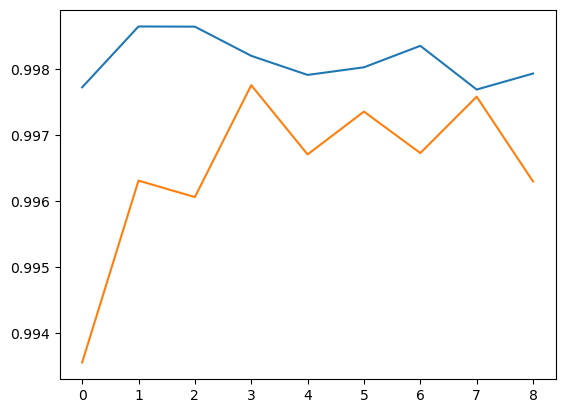

In [55]:
plt.plot(R2_all.detach
         ().numpy().mean(axis=2))

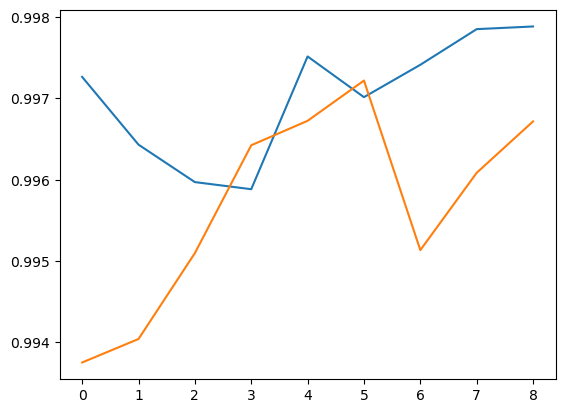

In [56]:
plt.plot(R2_lasso.detach().numpy().mean(axis=2))

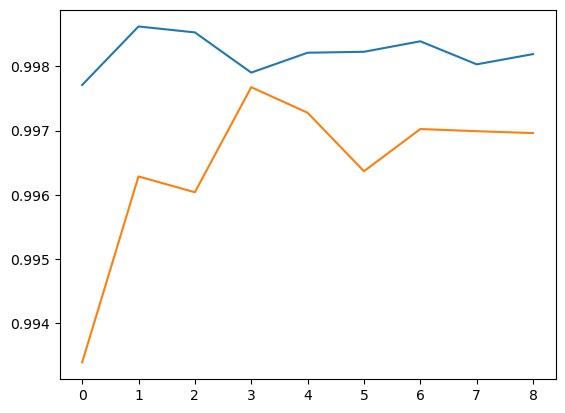

In [57]:
plt.plot(R2_lasso_i.detach().numpy().mean(axis=2))

In [58]:
R2_lasso_i

tensor([[[0.9982, 0.9976, 0.9986, 0.9976, 0.9993, 0.9968, 0.9991, 0.9982,
          0.9986, 0.9989, 0.9972, 0.9974, 0.9976, 0.9974, 0.9987, 0.9966,
          0.9975, 0.9977, 0.9976, 0.9971, 0.9975, 0.9989, 0.9972, 0.9974,
          0.9985, 0.9975, 0.9957, 0.9967, 0.9978, 0.9964],
         [0.9961, 0.9971, 0.9963, 0.9904, 0.9941, 0.9991, 0.9982, 0.9984,
          0.9979, 0.9974, 0.9447, 0.9967, 0.9952, 0.9971, 0.9943, 0.9942,
          0.9966, 0.9973, 0.9861, 0.9941, 0.9943, 0.9968, 0.9795, 0.9896,
          0.9981, 0.9982, 0.9990, 0.9885, 0.9983, 0.9981]],

        [[0.9996, 0.9982, 0.9958, 0.9982, 0.9984, 0.9994, 0.9991, 0.9990,
          0.9989, 0.9991, 0.9984, 0.9993, 0.9988, 0.9983, 0.9980, 0.9994,
          0.9995, 0.9990, 0.9973, 0.9978, 0.9993, 0.9986, 0.9987, 0.9992,
          0.9986, 0.9991, 0.9994, 0.9990, 0.9965, 0.9987],
         [0.9958, 0.9961, 0.9977, 0.9989, 0.9977, 0.9965, 0.9921, 0.9992,
          0.9984, 0.9995, 0.9985, 0.9976, 0.9982, 0.9970, 0.9984, 0.9943,
       

In [59]:
R2_lasso_i.detach().numpy().mean(axis=2)

array([[0.99771   , 0.9933845 ],
       [0.9986223 , 0.99628466],
       [0.99853   , 0.99603814],
       [0.9979032 , 0.997676  ],
       [0.99821305, 0.9972773 ],
       [0.9982278 , 0.99636596],
       [0.9983914 , 0.9970236 ],
       [0.99803215, 0.99698967],
       [0.99819195, 0.99696064]], dtype=float32)